# Whale Detection Challenge : MNASNet 1.0

Method overview : FFT to convert the sound tracks into spectrograms, and apply distinct preprocessing methods such as clipping, noise removal, PCEN and filters. After preprocessing we feed the spectrograms into state of the art light CNN models such as Resnet 18, VGG 16 or GoogleNet to identify right whale call patterns and perform classification. We may also try the removal of pooling layers in the networks and see if it causes better outcome.

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.3.1
Torchvision Version:  0.4.2


## Import and Load Data

In [2]:
num_classes = 2
batch_size = 32
num_epochs = 3
feature_extract = True
groups = 3
vis_batch = 4

In [3]:
data_dir = "data/"
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x+"_prep_10/"), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Model

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = models.mnasnet1_0(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, num_classes))
    input_size = 224  
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

## Training Section

### training fuction

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    history = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_acc

### optimizer

In [6]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


### run and save model

In [7]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist, best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), 'model_weight/mnasnet_'+str(num_epochs))

Epoch 0/2
----------
train Loss: 0.4942 Acc: 0.7713
val Loss: 0.5303 Acc: 0.7660

Epoch 1/2
----------
train Loss: 0.4285 Acc: 0.8017
val Loss: 0.5343 Acc: 0.7660

Epoch 2/2
----------
train Loss: 0.4072 Acc: 0.8157
val Loss: 0.5313 Acc: 0.7660

Training complete in 0m 19s
Best val Acc: 0.766000


### plot loss and accuracy

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc'])


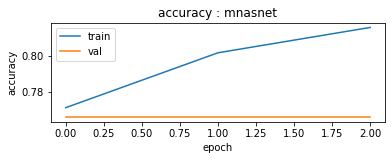

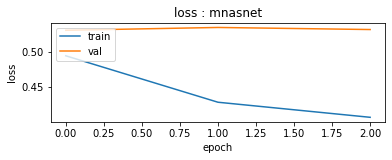

tensor(0.7660, device='cuda:0', dtype=torch.float64)


In [8]:
print(hist.keys())

#### Fill in plot #####
#Plot accuracy vs epoch
plt.subplot(211)

plt.plot(hist['train_acc'])
plt.plot(hist['val_acc'])
plt.title('accuracy : mnasnet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Plot loss vs epoch
plt.subplot(212)
plt.plot(hist['train_loss'])
plt.plot(hist['val_loss'])
plt.title('loss : mnasnet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print(best_acc)

### load model and prediction

In [9]:
def forward_vis(vis_loader, groups):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.mnasnet1_0()
    set_parameter_requires_grad(model, feature_extract)
    model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, num_classes))
    # load best model weights
    model.load_state_dict(torch.load('model_weight/mnasnet_'+str(num_epochs)))
    model.to(device)
    model.eval()   # Set model to evaluate mode
    # Iterate over data.
    cnt=0
    vis_dict = {'inputs':np.empty([groups,vis_batch,3,224,224]),'outputs':np.empty([groups,vis_batch,num_classes]),'labels':np.empty([groups,vis_batch]),'preds':np.empty([groups,vis_batch])}
    for inputs, labels in vis_loader:
            if(cnt==groups):
                break;
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            vis_dict['inputs'][cnt,:,:,:,:]=inputs.cpu().numpy()
            vis_dict['labels'][cnt,:]=labels.cpu().numpy()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                vis_dict['outputs'][cnt,:,:]=outputs.cpu().numpy()
                vis_dict['preds'][cnt,:]=preds.cpu().numpy()
            cnt+=1
            

    time_elapsed = time.time() - since
    print()
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return vis_dict

vis_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=vis_batch, shuffle=True, num_workers=8)
vis_dict = forward_vis(vis_loader, groups)
print(vis_dict['inputs'].shape)
print(vis_dict['outputs'].shape)
print(vis_dict['labels'].shape)
print(vis_dict['preds'].shape)


Inference complete in 0m 1s
(3, 4, 3, 224, 224)
(3, 4, 2)
(3, 4)
(3, 4)


### visualization 

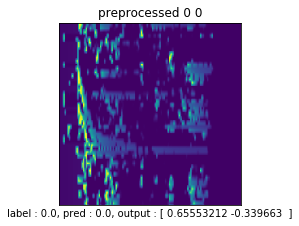

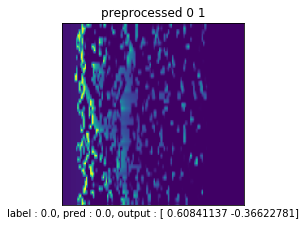

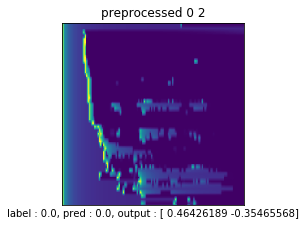

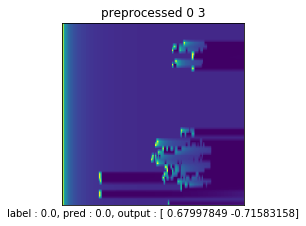

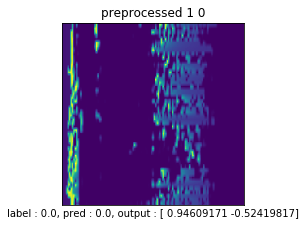

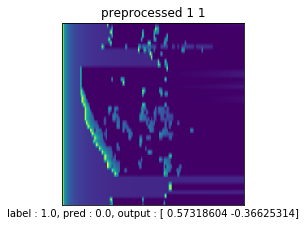

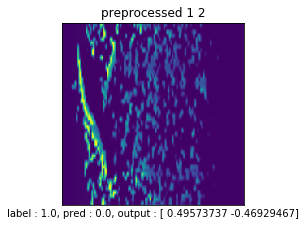

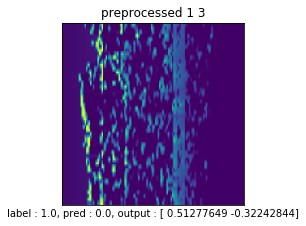

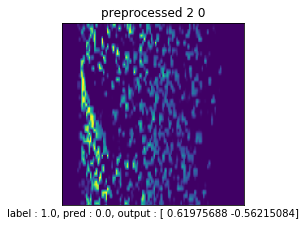

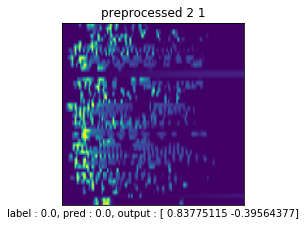

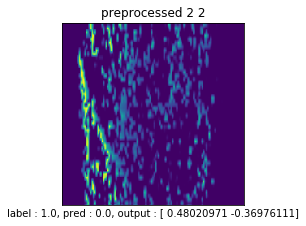

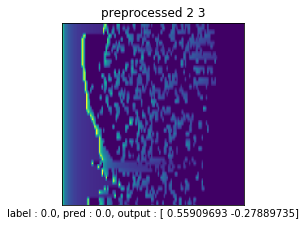

In [10]:
for i in range(groups) :
    for j in range(vis_batch) :
        plt.figure(figsize=(15,15))
        plt.subplot(groups,vis_batch,4*i+j+1)
        image = np.moveaxis(np.squeeze(vis_dict['inputs'][i,j]), 0, -1)
        image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
        plt.imshow(image)
        plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        left=False,         # ticks along the left edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
        plt.title('preprocessed '+str(i)+' '+str(j))
        plt.xlabel('label : '+str(vis_dict['labels'][i,j])+', pred : '+str(vis_dict['preds'][i,j])+', output : '+str(vis_dict['outputs'][i,j,:]))
plt.show()